In [8]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

In [9]:
df = pd.read_csv('../datasets/data/BBC_News/documents.csv')
df.head()

,document,class_name,class_index,dataset_type
0,hit shelf combine medium player phone gaming g...,tech,3,train
1,bid hope join host apply host tournament aim r...,sport,1,train
2,lord wrong detainee straw straw attack decisio...,politics,4,train
3,leak answer minister explain budget detail pri...,politics,4,train
4,delight manager pay tribute goal striker beat ...,sport,1,train


In [10]:
def plot_embeddings_2D(embeddings_by_class: dict, model_name: str):
    plt.figure(figsize=(10, 10))

    title = f'Embeddings 2D | {model_name.replace("_", " ").capitalize()}'
    plt.title(title, fontsize=16, fontweight='bold')

    for class_name in embeddings_by_class.keys():
        pts_x, pts_y = [], []
        for pt in embeddings_by_class[class_name]:
            pts_x.append(pt[0])
            pts_y.append(pt[1])

        plt.scatter(pts_x, pts_y, label=class_name)

    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../figures/keyword_analysis_embeddings_2D_{model_name}.png')
    plt.show()

In [11]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['document'])]
doc2vec_model = Doc2Vec(documents, vector_size=2, window=2, min_count=1, workers=4)

doc2vec_model.infer_vector(['this', 'is', 'a', 'test', 'document', 'for', 'doc2vec'])

array([-0.11553331,  0.14386334], dtype=float32)

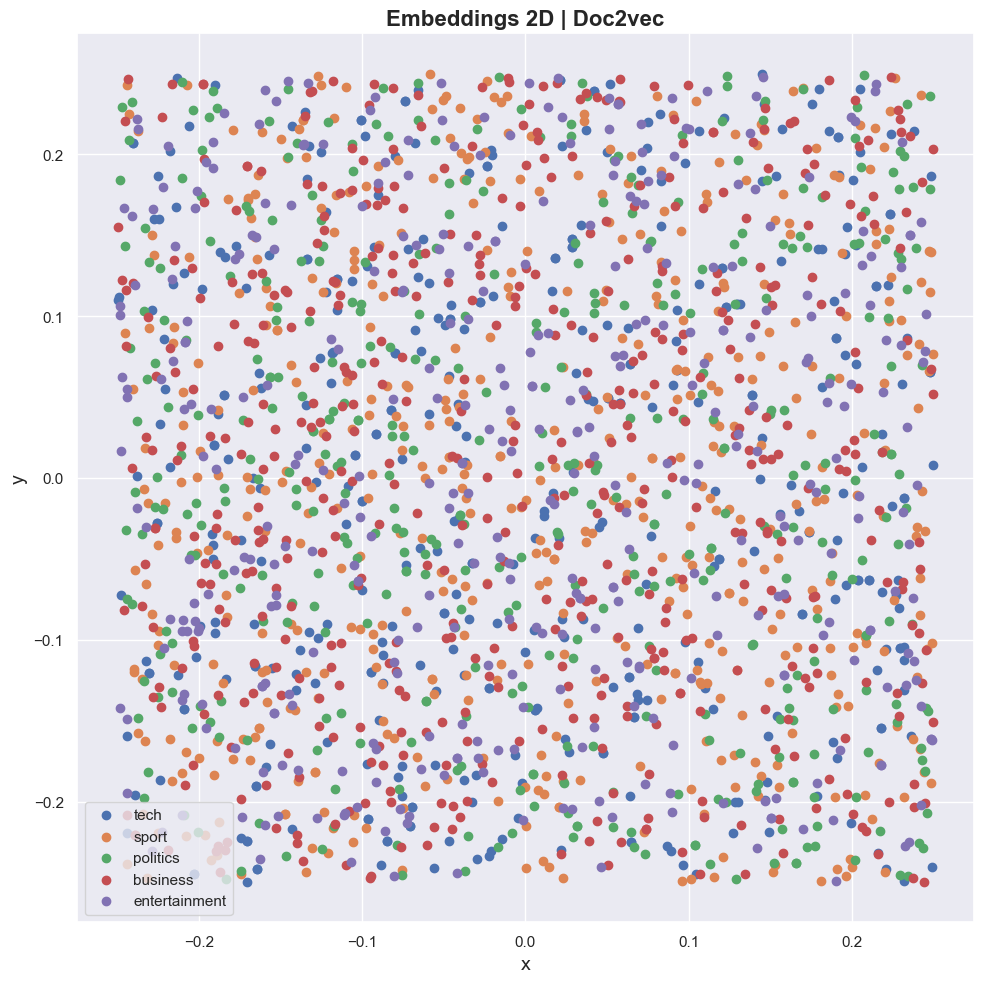

In [12]:
embeddings_by_class = {}
for i, class_name in enumerate(df['class_name'].unique()):
    embeddings_by_class[class_name] = []

for i, doc in enumerate(df['document']):
    vector = doc2vec_model.infer_vector(doc.split(' '))
    embeddings_by_class[df['class_name'][i]].append(vector)

plot_embeddings_2D(embeddings_by_class, 'doc2vec')

In [13]:
sentransformer_model = SentenceTransformer('all-MiniLM-L6-v2')

pca = PCA(n_components=2)
pca.fit(sentransformer_model.encode(df['document']))

PCA(n_components=2)

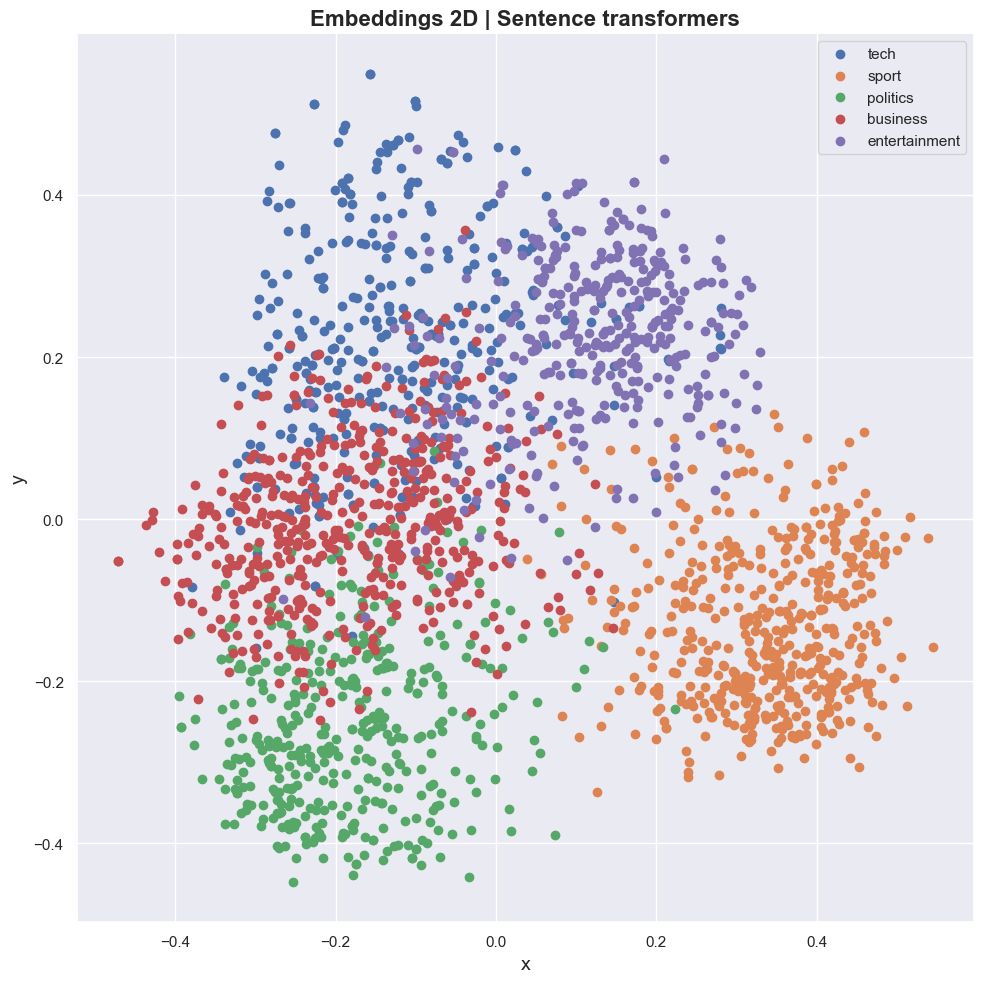

In [14]:
embeddings_by_class = {}
for i, class_name in enumerate(df['class_name'].unique()):
    embeddings_by_class[class_name] = []

for i, doc in enumerate(df['document']):
    vector = sentransformer_model.encode(doc)
    vector = pca.transform([vector])[0]
    embeddings_by_class[df['class_name'][i]].append(vector)

plot_embeddings_2D(embeddings_by_class, 'sentence_transformers')

In [47]:
def get_2d_embeddings_for_doc(doc: str, model_name: str):
    if model_name == 'doc2vec':
        vector = doc2vec_model.infer_vector(doc.split(' ')) 
        return vector
    elif model_name == 'sentence_transformers':
        vector = sentransformer_model.encode(doc)
        vector = pca.transform([vector])[0]
        return vector
    
def get_2d_embeddings_for_classes(model_name: str, n_words: int = 1):
    spacy_keywords_df = pd.read_csv('../lbl2vec/cache/BBC_News_spacy_keywords.csv')
    spacy_keywords_df['class_result_keywords'] = spacy_keywords_df['class_result_keywords'].apply(lambda x: x[1:-1].replace("'", '').split(', '))
    labels_df = pd.read_csv('../datasets/data/BBC_News/labels.csv')

    embeddings_by_class = {}
    keywords_by_class = {}

    for idx, row in spacy_keywords_df.iterrows():
        class_name = labels_df[labels_df['class_keywords'] == row['class_raw_keywords']]['class_name'].values[0]
        keywords_by_class[class_name] = ' '.join(row['class_result_keywords'][:n_words])

    for class_name in keywords_by_class.keys():
        if model_name == 'doc2vec':
            embeddings_by_class[class_name] = doc2vec_model.infer_vector(keywords_by_class[class_name].split(' '))
        elif model_name == 'sentence_transformers':
            vector = sentransformer_model.encode(keywords_by_class[class_name])
            vector = pca.transform([vector])[0]
            embeddings_by_class[class_name] = vector

    return embeddings_by_class

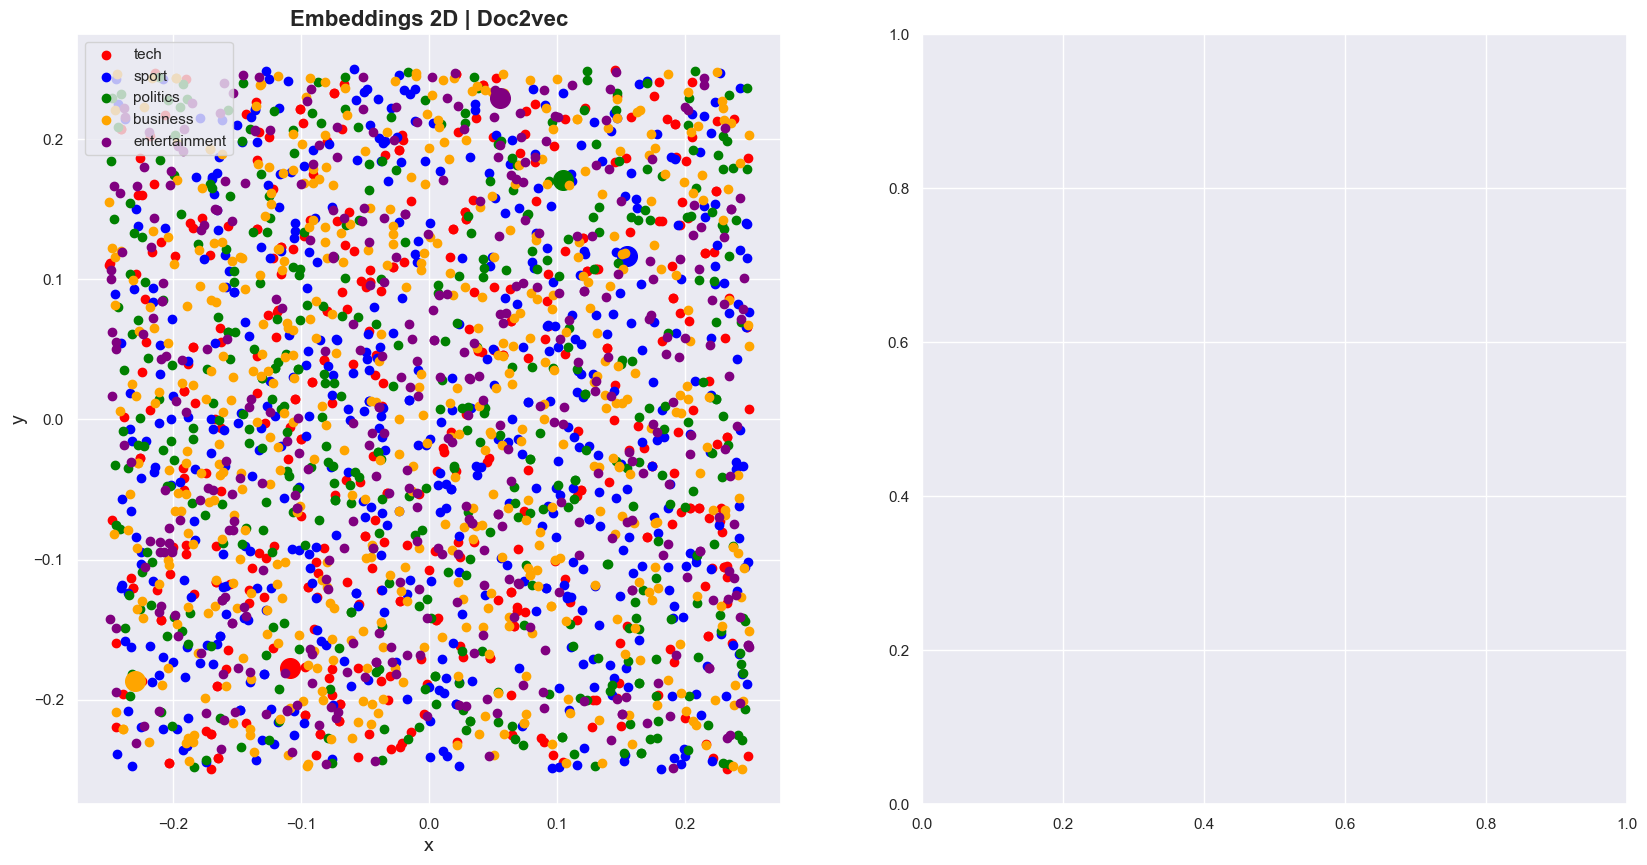

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, model_name in enumerate(['doc2vec']):
    embeddings_by_class = get_2d_embeddings_for_classes(model_name, 1)

    for j, class_name in enumerate(df['class_name'].unique()):
        pts_x, pts_y = [], []
        for doc in df[df['class_name'] == class_name]['document']:
            vector = get_2d_embeddings_for_doc(doc, model_name)
            pts_x.append(vector[0])
            pts_y.append(vector[1])

        ax[i].scatter(pts_x, pts_y, label=class_name, color=colors[j])
        ax[i].scatter(embeddings_by_class[class_name][0], embeddings_by_class[class_name][1], marker='o', s=200, color=colors[j])

    ax[i].set_xlabel('x', fontsize=14)
    ax[i].set_ylabel('y', fontsize=14)
    ax[i].set_title(f'Embeddings 2D | {model_name.replace("_", " ").capitalize()}', fontsize=16, fontweight='bold')
    ax[i].legend()